In [1]:
!pip install fastai --upgrade
!pip install timm wwf

     |████████████████████████████████| 194kB 8.9MB/s 
     |████████████████████████████████| 61kB 6.8MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 245kB 7.5MB/s 


In [2]:
!wget https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1 -O erm.zip

--2021-03-01 07:21:33--  https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/cb3g53z4pbtaqvl/erm.zip [following]
--2021-03-01 07:21:34--  https://www.dropbox.com/s/dl/cb3g53z4pbtaqvl/erm.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd910f02d7f7830d2511b849a34.dl.dropboxusercontent.com/cd/0/get/BJ3fzdRBKYvuKsCH02xNky4lWX0h4RT25Aw4Pgp3NXAbJXYCKHz19viLPGyh279UvN5ja7Q23kzshaboj9WxZj8VlUgxtd0h7vYCkSGUTnD0qxcDV7jvSpE_hrkrpJIpOsQ/file?dl=1# [following]
--2021-03-01 07:21:34--  https://ucd910f02d7f7830d2511b849a34.dl.dropboxusercontent.com/cd/0/get/BJ3fzdRBKYvuKsCH02xNky4lWX0h4RT25Aw4Pgp3NXAbJXYCKHz19viLPGyh279UvN5ja7Q23kzshaboj9WxZj8VlUgxtd0h7vYCkSGUTnD0qxcDV7jvSpE_hrkr

In [3]:
!unzip erm.zip

Archive:  erm.zip
   creating: dataset/
   creating: dataset/test/
   creating: dataset/test/no/
  inflating: dataset/test/no/anonymized_1421704.jpg  
  inflating: dataset/test/no/anonymized_336537.jpg  
  inflating: dataset/test/no/anonymized_569526.jpg  
  inflating: dataset/test/no/anonymized_196860.jpg  
  inflating: dataset/test/no/anonymized_920184.jpg  
  inflating: dataset/test/no/anonymized_1348815.jpg  
  inflating: dataset/test/no/anonymized_225304.jpg  
  inflating: dataset/test/no/anonymized_816099.jpg  
  inflating: dataset/test/no/anonymized_260226.jpg  
  inflating: dataset/test/no/anonymized_1619231.jpg  
  inflating: dataset/test/no/anonymized_1314755.jpg  
  inflating: dataset/test/no/anonymized_1182585.jpg  
  inflating: dataset/test/no/anonymized_656024.jpg  
  inflating: dataset/test/no/anonymized_198917.jpg  
  inflating: dataset/test/no/anonymized_246204.jpg  
  inflating: dataset/test/no/anonymized_324557.jpg  
  inflating: dataset/test/no/anonymized_492637.jpg

In [1]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *

In [2]:
path = Path('dataset/')
trainPath = path/'train'
testPath = path/'test'

In [3]:
def getDataBlock(presize=512,size=384):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])

In [4]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=16)

In [5]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='vit384'),
    ReduceLROnPlateau(patience=1)
]

In [6]:
import timm

In [7]:
learn = Learner(dls512,timm.models.vision_transformer.vit_base_patch16_384(num_classes=2,pretrained=True),metrics=accuracy,cbs=callbacks)

In [8]:
#learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.667916,0.635491,0.620795,05:37


Better model found at epoch 0 with valid_loss value: 0.6354913711547852.


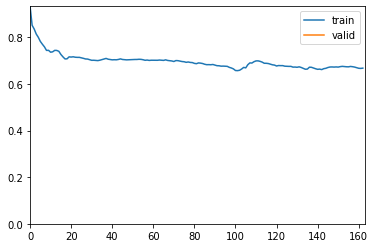

epoch,train_loss,valid_loss,accuracy,time
0,0.535709,0.508448,0.750765,05:36
1,0.499074,0.525186,0.753823,05:37
2,0.465637,0.508910,0.756881,05:37
3,0.456209,0.535363,0.753823,05:37


Better model found at epoch 0 with valid_loss value: 0.5084481239318848.


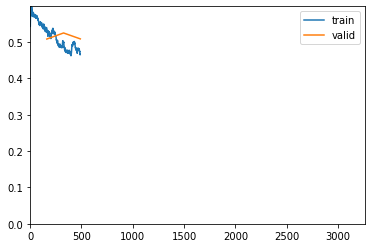

Epoch 1: reducing lr to 1.9944412973047346e-06
Epoch 2: reducing lr to 2.993575342979093e-06
No improvement since epoch 0: early stopping


In [9]:
learn.fine_tune(20,base_lr=1e-4)

In [10]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

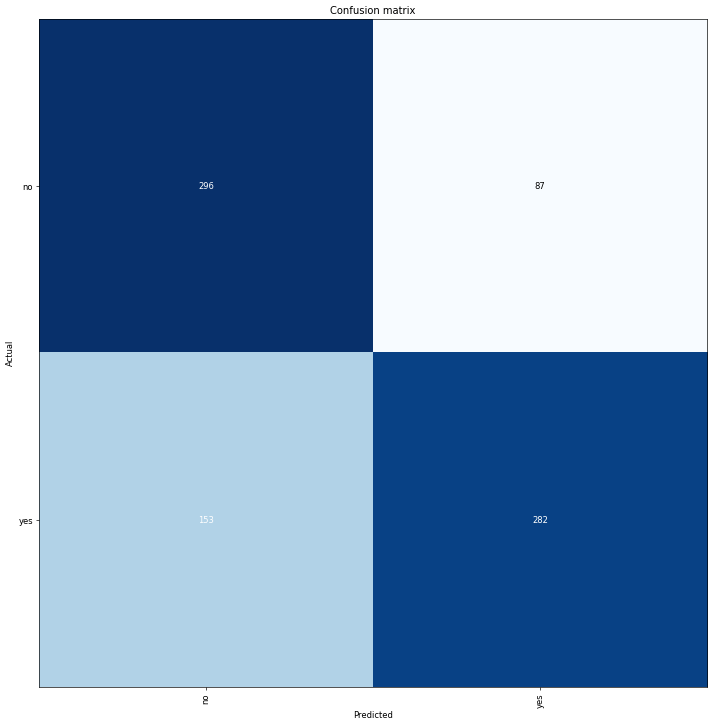

In [11]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [12]:
learn.metrics=[accuracy,Precision(),Recall()]

In [13]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7066014409065247.


(#4) [0.5659719705581665,0.7066014409065247,0.7642276422764228,0.6482758620689655]